In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
cd C:\Users\kush.patel\Desktop\School\Covid

C:\Users\kush.patel\Desktop\School\Covid


In [3]:
lockdown_dates = pd.read_csv("data/countryLockdowndatesJHUMatch.csv")
global_mobility = pd.read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=94537edba4db1128")
emissions_master = pd.read_csv("data/ad_aqi_tracker_data_Master.csv")

C:\Users\kush.patel\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Get Emissions data for New Jersey
nj_emissions = emissions_master.copy()
nj_mobility = global_mobility.copy()[(global_mobility.country_region == 'United States')][(global_mobility.sub_region_1 == 'New Jersey')]

C:\Users\kush.patel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
# drop dates with missing data
nj_emissions = nj_emissions[nj_emissions["5-year Average (2015-2019)"] != "."]

In [6]:
nj_emissions['5-year Average (2015-2019)'] = pd.to_numeric(nj_emissions['5-year Average (2015-2019)'])

In [8]:
# Get all NJ counties 
nj_counties = set(nj_mobility['sub_region_2'].tolist())
nj_counties = {x for x in nj_counties if x==x}
nj_counties = list(nj_counties)

# Make the emmisions county name consisitent with the mobility dataset county name
nj_emissions['County'] = [county + ' County' for county in nj_emissions['County']]

In [11]:
# Remove unused features from the mobility dataset
nj_mobility_mask = nj_mobility['sub_region_2'].isin(nj_counties)
nj_mobility_selected = nj_mobility.loc[nj_mobility_mask,:].drop(['country_region_code', 'country_region', 'sub_region_1'], axis=1)

nj_emissions_mask = nj_emissions['County'].isin(nj_counties)
nj_emissions_selected = nj_emissions.loc[nj_emissions_mask,:].drop(['Main Pollutant', 'Site Name', 'Site ID', 'Source'], axis =1)

# Make feature names consistent in two tables
nj_mobility_selected = nj_mobility_selected.rename(columns={'sub_region_2':'County', 'date':'Date'})

In [12]:
# Change the values to DATE format in both datasets
nj_mobility_selected['Date'] = pd.to_datetime(nj_mobility_selected['Date'])
nj_emissions_selected['Date'] = pd.to_datetime(nj_emissions_selected['Date'])
nj_emissions_selected['Date'] = nj_emissions_selected['Date'].dt.strftime('%m/%d/%Y')
nj_mobility_selected['Date'] = nj_mobility_selected['Date'].dt.strftime('%m/%d/%Y')

In [50]:
# Merge the two tables based on Date and County names
both_nj = pd.merge(nj_emissions_selected, nj_mobility_selected, left_on=['County','Date'], right_on=['County','Date'])

In [14]:
both_nj.dtypes

Date                                                   object
 AQI Value                                              int64
County                                                 object
20-year High (1980-2019)                               object
20-year Low (1980-2019)                                object
5-year Average (2015-2019)                            float64
metro_area                                             object
iso_3166_2_code                                        object
census_fips_code                                      float64
retail_and_recreation_percent_change_from_baseline    float64
grocery_and_pharmacy_percent_change_from_baseline     float64
parks_percent_change_from_baseline                    float64
transit_stations_percent_change_from_baseline         float64
workplaces_percent_change_from_baseline               float64
residential_percent_change_from_baseline              float64
dtype: object

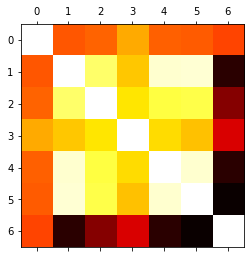

In [59]:
#Simple correlation matrix
#Just the first column/row is interesting because that is the AQI correlation to the mobility types
plt.matshow(both_nj[[
                            ' AQI Value', 
                            'retail_and_recreation_percent_change_from_baseline', 
                            'grocery_and_pharmacy_percent_change_from_baseline',
                            'parks_percent_change_from_baseline',
                            'transit_stations_percent_change_from_baseline',
                            'workplaces_percent_change_from_baseline',
                            'residential_percent_change_from_baseline']].corr(), cmap="hot")

In [25]:
# Plot the emissions and mobility data interactively

def plot_nj_county(county_name):
    county_both = both_nj[both_nj['County'] == county_name]
    print(county_both.shape)
    plt.figure(figsize=(30,5))
    plt.plot(county_both['Date'], county_both[' AQI Value'] - county_both['5-year Average (2015-2019)'], label="AQI")
    plt.plot(county_both['Date'], county_both['retail_and_recreation_percent_change_from_baseline'], label = "retail")
    plt.plot(county_both['Date'], county_both['workplaces_percent_change_from_baseline'], label = "workplace")
    plt.plot(county_both['Date'], county_both['transit_stations_percent_change_from_baseline'], label = "transit")
    plt.plot(county_both['Date'], county_both['parks_percent_change_from_baseline'], label = "parks")
    plt.plot(county_both['Date'], county_both['grocery_and_pharmacy_percent_change_from_baseline'], label = "grocery")
    plt.axvline(x='03/18/2020')
    plt.legend(loc="upper center")
    plt.xticks(rotation=60)
    plt.show()
    
@interact
def choose_nj_county(county = nj_emissions['County'].unique()):
    print('chosen: ' + county)
    plot_nj_county(county)

interactive(children=(Dropdown(description='county', options=('Atlantic County', 'Bergen County', 'Camden Coun…

In [55]:
# Calculate the average mobility
both_nj["Average Mobility"] = (both_nj.retail_and_recreation_percent_change_from_baseline + both_nj.grocery_and_pharmacy_percent_change_from_baseline + both_nj.parks_percent_change_from_baseline + both_nj.transit_stations_percent_change_from_baseline + both_nj.workplaces_percent_change_from_baseline + both_nj.residential_percent_change_from_baseline) / 5

In [ ]:
# drop NaN rows
both_nj.drop(columns=["metro_area", "iso_3166_2_code", "census_fips_code"], inplace=True)
both_nj.dropna(inplace=True)

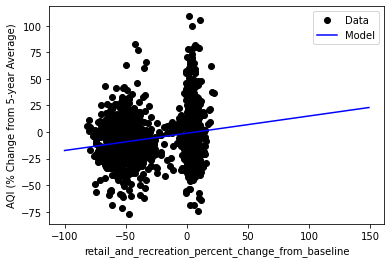

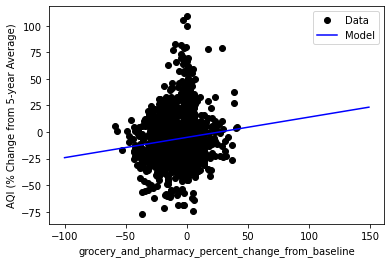

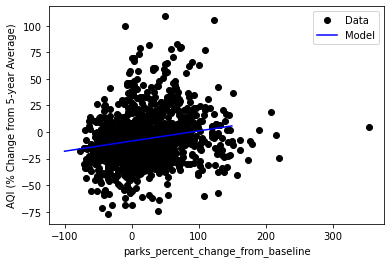

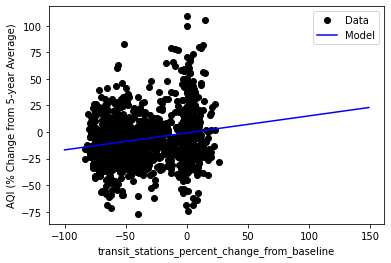

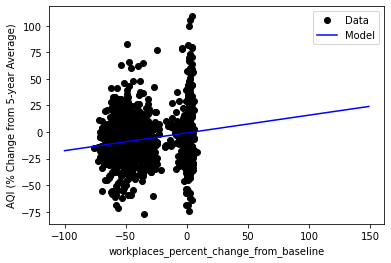

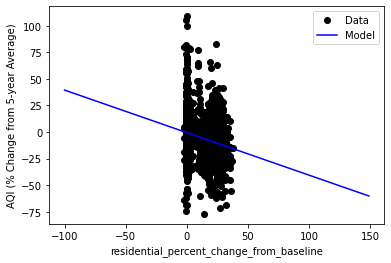

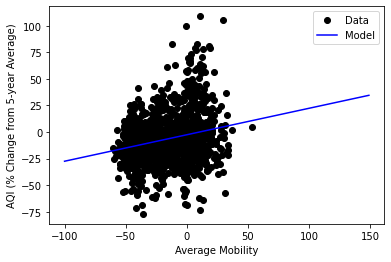

In [57]:
# Plot the mobility versus AQI to see if increased mobility correlates to an increased AQI value.
col = both_nj.columns[6:]
y = (both_nj[" AQI Value"] - both_nj["5-year Average (2015-2019)"]) / both_nj["5-year Average (2015-2019)"] * 100
for i in col:
    x = both_nj[i]
    c = np.polyfit(x,y,1)
    p = np.poly1d(c)
    fig = plt.figure()
    ax1  = fig.add_subplot(111)
    plt.plot(x, y, 'ko', label="Data")
    x_extrapolate = range(-100,150)
    plt.plot(x_extrapolate,p(x_extrapolate), 'b-')
    plt.xlabel(i)
    plt.ylabel("AQI (% Change from 5-year Average)")
    plt.legend(["Data","Model"])
    plt.show()